# Term Deposit Marketing
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Feb 27, 2023

## Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

## Data Wrangling and Preprocessing

First let's load and take a look at the dataset.

In [2]:
df = pd.read_csv('./data/term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


It appears that there is no `Null` values in the dataset. However, we do notice that the dataset is a mix of categorical features and numerical features. We would need to convert the categorical features into numerical representations so that we can apply statistical modeling.

### Processing Categorical Features

In [5]:
def show_categorical_col(df):
    category_features = df.select_dtypes(['object']).columns.values
    print(f'There are {len(category_features)} categorical features in the dataset.')
    print(f'The categorical features are {category_features}')
    display(df[category_features].head())
    return category_features
category_features = show_categorical_col(df)

There are 9 categorical features in the dataset.
The categorical features are ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'y']


,job,marital,education,default,housing,loan,contact,month,y
0,management,married,tertiary,no,yes,no,unknown,may,no
1,technician,single,secondary,no,yes,no,unknown,may,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,no
4,unknown,single,unknown,no,no,no,unknown,may,no


Now let's examine the individual categorical columns. We will define a function to help us explore a particular column.

In [6]:
def explore_categorical(df, col):
    # Display information of a column if it is categorical
    if df[col].dtypes == 'object':
        unique_cat = len(df[col].unique())
        print(f'Column Name: {col} \n{20*"-"}')
        print(f'Feature {col} has {unique_cat} unique categories\n')
        print(df[col].value_counts(normalize=True))
        plt.figure(figsize=(10, 1.2*unique_cat))
        sns.countplot(y=col, data=df, order = df[col].value_counts().index, color="#58508d")
        plt.show()
        print()

#### Preprocessing `y` (target variable)

Firstly let's take a look at the target variable `y`.

Column Name: y 
--------------------
Feature y has 2 unique categories

no     0.9276
yes    0.0724
Name: y, dtype: float64


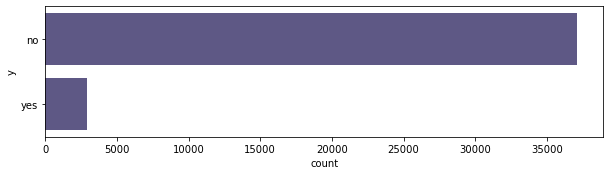

In [7]:
explore_categorical(df, 'y')

92.76% of the customer are not subscribed to a term deposit and only 7.24% of them did. The classes are not balanced and we need to address this issue. Accuracy will unlikely to be a good metric when designing our model and we would need to consider the other metrics for evaluation.

We will map `y` into a binary variable with 0 for no and 1 for yes.

In [8]:
df['y'] = df['y'].map({'no':0, 'yes':1})

#### Preprocessing `job`

Column Name: job 
--------------------
Feature job has 12 unique categories

blue-collar      0.234575
management       0.204150
technician       0.171300
admin            0.112075
services         0.097750
retired          0.035925
self-employed    0.035350
entrepreneur     0.035125
unemployed       0.027600
housemaid        0.027175
student          0.013100
unknown          0.005875
Name: job, dtype: float64


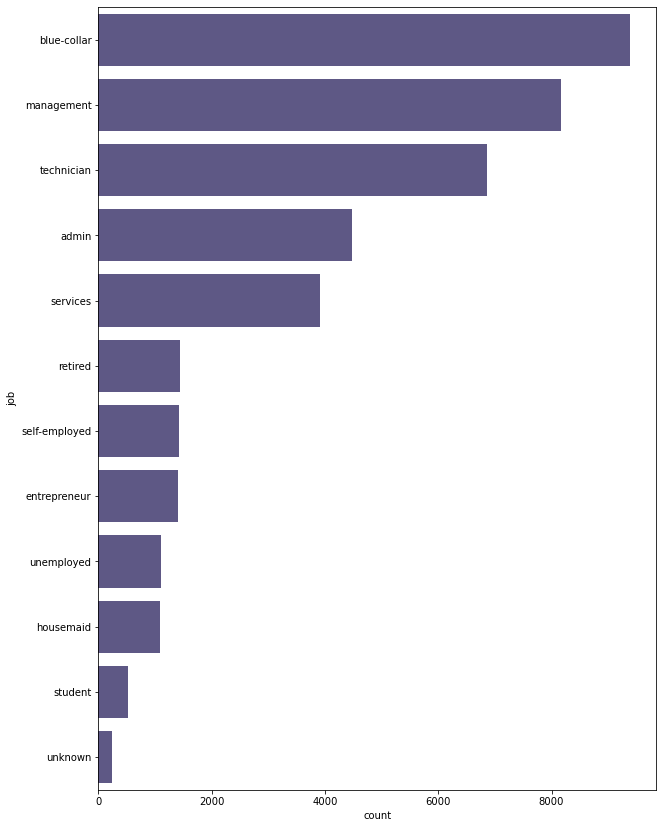

In [9]:
explore_categorical(df, 'job')

The majority of the customers work as `blue-collar`, `management` and `technician`, taking up 23.46%, 20.42 and 17.13% of the total customer base respectively. There are to the lesser extent, `admin` and `services` workers, at 11.2% and 9.78%.

The rest of the job types only accounts for about 18% of the population. The job types with lower population are typically short on deposit funds, which could be explanation of why they do not make up the majority of the business. There are also 0.58% of customers with unknown job types. We can group these job types into one single category called `others`.

In [10]:
job_types = ['blue-collar', 'management', 'technician', 'admin', 'services']
df['job'] = np.where(df['job'].isin(job_types), df['job'], 'others')

#### Preprocessing `marital`

Column Name: marital 
--------------------
Feature marital has 3 unique categories

married     0.609650
single      0.272225
divorced    0.118125
Name: marital, dtype: float64


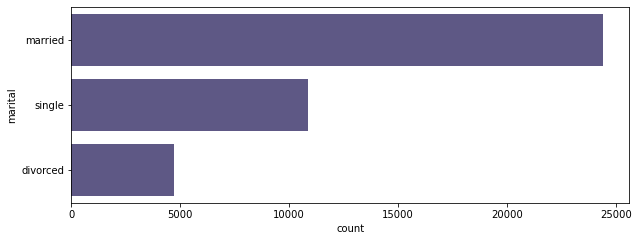

In [11]:
explore_categorical(df, 'marital')

72.8% of the customers are either married or divorced, in comparison to only 27.2% of the customer who are single. This indicates that the majority of the customers are middle-aged or beyond.

#### Preprocessing `education`

Column Name: education 
--------------------
Feature education has 4 unique categories

secondary    0.524825
tertiary     0.280150
primary      0.156750
unknown      0.038275
Name: education, dtype: float64


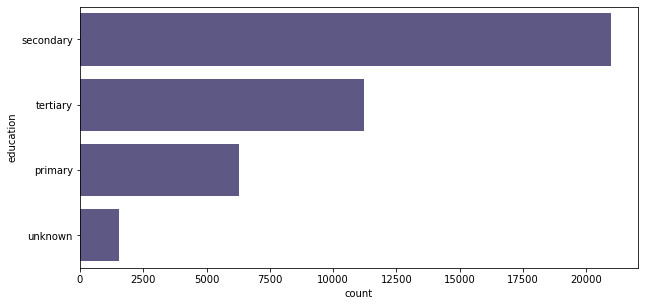

In [12]:
explore_categorical(df, 'education')

52.48% of the customers have completed a secondary education. 28% of the customers have completed post-secondary eduction whereas 15.68% of the customers only have completed a primary education. There are 3.8% of the customers with unknown education background. We can lump these in together with `secondary`.

In [13]:
df.loc[df['education']=='unknown', 'education'] = 'secondary'

#### Preprocessing `default`

Column Name: default 
--------------------
Feature default has 2 unique categories

no     0.979775
yes    0.020225
Name: default, dtype: float64


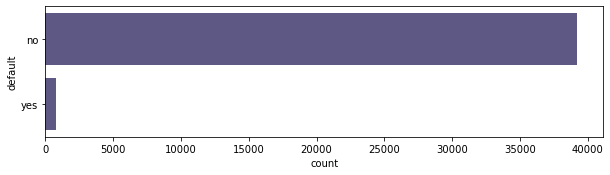

In [14]:
explore_categorical(df, 'default')

The overwhelmingly majority of 98% of the customer do not have credit in default whereas 2% only them do. We might consider dropping this column since the categories are heavily imbalanced.

We should firstly verify that `default` is not contributing a lot to the classification.

In [15]:
df['default'].value_counts()

no     39191
yes      809
Name: default, dtype: int64

In [16]:
df[df['default']=='yes']['y'].value_counts()

0    760
1     49
Name: y, dtype: int64

Out of 809 customers without credit in default, only 49 of them are subscribed to a term deposit, which is similar to the ratio of the class distribution. Therefore, it should be safe to conclude that `default` is not key factor in classifying `y` and can be removed.

In [17]:
df.drop('default', axis=1, inplace=True)

#### Preprocessing `housing` and `loan`

Column Name: housing 
--------------------
Feature housing has 2 unique categories

yes    0.600775
no     0.399225
Name: housing, dtype: float64


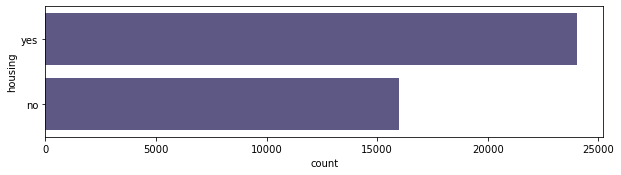

In [18]:
explore_categorical(df, 'housing')

60% of the customers have a housing loan and 40% of them do not.

Column Name: loan 
--------------------
Feature loan has 2 unique categories

no     0.82675
yes    0.17325
Name: loan, dtype: float64


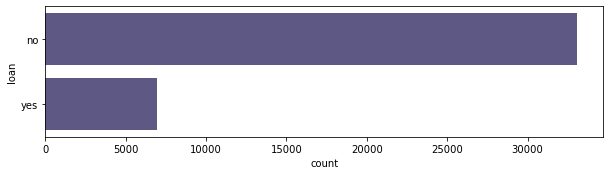

In [19]:
explore_categorical(df, 'loan')

82.7% of the customers do not have a personal loan and 17.3% of them do. The distribution are not similar to the distribution of `housing`.

We will map `housing` and `loan` into a binary variable with 0 for no and 1 for yes.

In [20]:
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})

#### Preprocessing `contact`

Column Name: contact 
--------------------
Feature contact has 3 unique categories

cellular     0.622850
unknown      0.319125
telephone    0.058025
Name: contact, dtype: float64


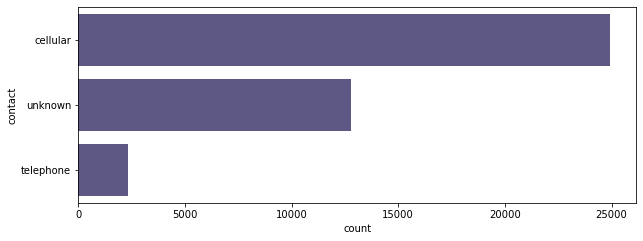

In [21]:
explore_categorical(df, 'contact')

The majority of the customers at 62.3% uses cellular to make communication and only 5.8% of the customers uses telephone. There are 31.9% of customer with unknown communication method. 

We make the argument that it is reasonable to combine `unknown` and `telephone` since the bank does not explicitly know that the customer uses cellular as the communication method. We can store the new information into a column called `use_cellular`

In [22]:
df['use_cellular'] = df['contact'].map({'cellular': 1, 'unknown': 0, 'telephone': 0})
df.drop('contact', axis=1, inplace=True)

#### Preprocessing `month`

Column Name: month 
--------------------
Feature month has 11 unique categories

may    0.338300
jul    0.159500
aug    0.130375
jun    0.118350
nov    0.089950
apr    0.067950
feb    0.057400
jan    0.029400
mar    0.006450
oct    0.002000
dec    0.000325
Name: month, dtype: float64


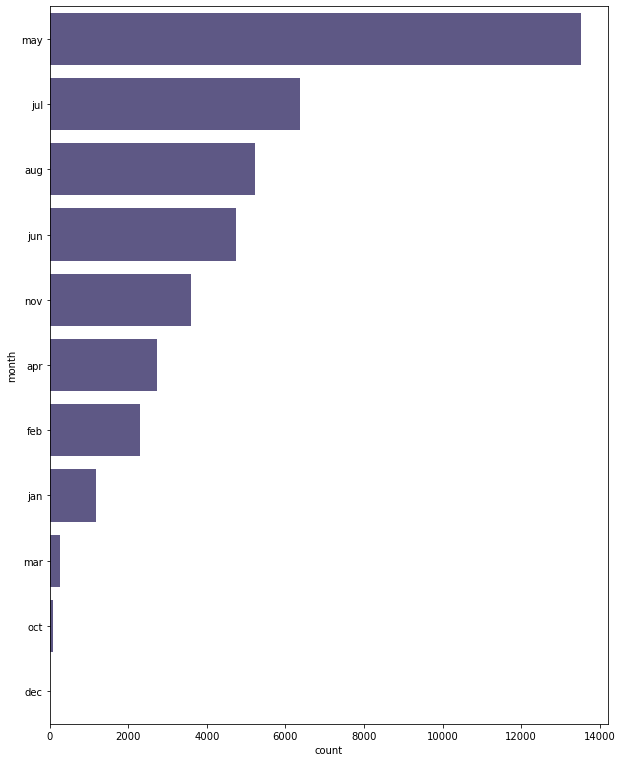

In [23]:
explore_categorical(df, 'month')

33.8% of the customers made the last contact in May and there are rarely any customer last contacted in October and December, at 0.2% and 0.03% respectively. Maybe there existed some customer searching campaign during the early to mid summer.

One option is to group the month into quarters.

In [24]:
df['quarter'] = pd.to_datetime(df['month'], format='%b').dt.quarter

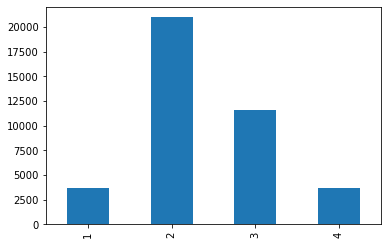

In [25]:
df['quarter'].value_counts().sort_index().plot(kind='bar')
plt.show()

Interesting to note above, very little contact happened during Q1 and Q4. The majority of the contacts were made in the second quarter with a sharp decline in Q3.

Also, since majority of the last contacts happened in May, July, August and June, we could consider these months `heavy_months` and create a binary feature to decide if the last call happened in a heavy month.

In [26]:
heavy_months = ['may', 'jul', 'aug', 'jun']
df['heavy_months'] = 0
df.loc[df['month'].isin(heavy_months), 'heavy_months'] = 1

In [27]:
df.drop('month', axis=1, inplace=True)

After processing all the categorical columns, we can go back to numerical columns.

### Preprocessing Numerical Features

Similar to the categorical columns, we will define a function to help visualize the numerical columns.

In [28]:
def explore_numerical(df, col):
    if df[col].dtypes in ['int', 'float']:
        print(f'Column Name: {col} \n{20*"-"}')
        print(f'minimum value: {df[col].min()}')
        print(f'median value: {df[col].median()}')
        print(f'maximum value: {df[col].max()}')
        print(f'mean value: {df[col].mean()}')
        plt.figure(figsize=(7.5, 7.5))
        sns.boxplot(y=col, data=df, color="#58508d")
        plt.show()
        print()

#### Preprocessing `balance`

Column Name: balance 
--------------------
minimum value: -8019
median value: 407.0
maximum value: 102127
mean value: 1274.27755


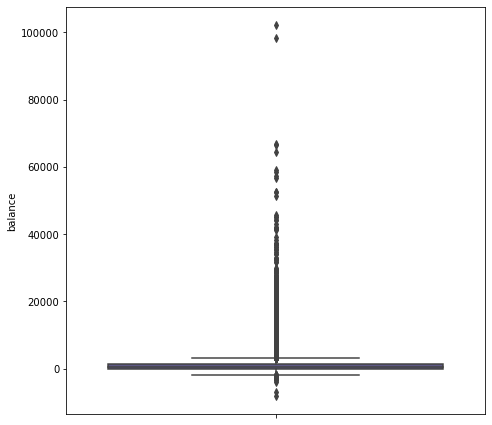

In [29]:
explore_numerical(df, 'balance')

It seems that the majority of the account balance are below 2000 but the highest balance goes up to 102127.

#### Preprocessing `campaign`

Column Name: campaign 
--------------------
minimum value: 1
median value: 2.0
maximum value: 63
mean value: 2.882175


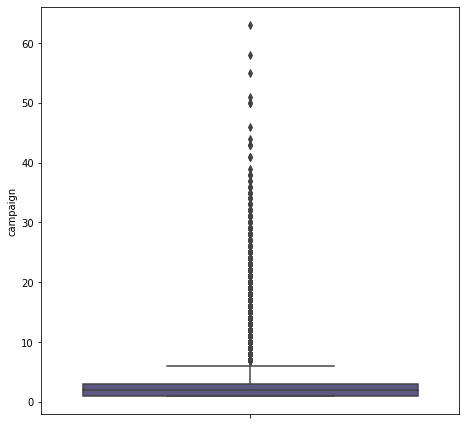

In [30]:
explore_numerical(df, 'campaign')

It appears that over half of the data points belongs in campaign 1 and 2. Let's take a deeper look into the specific distribution of the data.

In [31]:
df['campaign'].value_counts()

1     14718
2     11153
3      4970
4      3297
5      1642
6      1228
7       699
8       526
9       318
10      262
11      197
12      154
13      131
14       93
15       83
16       78
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64

The campaign 1 and 2 makes up the majority of the data. We categorize the values as `1`, `2` and `others` as the values are not statistically semantic.

In [32]:
df['campaign'] = np.where(df['campaign'].isin([1,2]), df['campaign'].apply(lambda x: str(x)), 'others')

#### Preprocessing `day`

Column Name: day 
--------------------
minimum value: 1
median value: 17.0
maximum value: 31
mean value: 16.017225


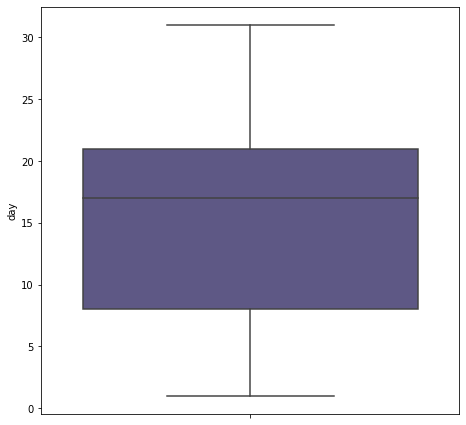

In [33]:
explore_numerical(df, 'day')

Since the `day` value is unlikely to contribute to the classification, we will drop it from the dataset.

In [34]:
df.drop('day', axis=1, inplace=True)

### Create dummy df

Now that we are done preprocessing the columns, we can transfer the df into a dummy df.

In [35]:
dummy_df = pd.get_dummies(df)

In [36]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  40000 non-null  int64
 1   balance              40000 non-null  int64
 2   housing              40000 non-null  int64
 3   loan                 40000 non-null  int64
 4   duration             40000 non-null  int64
 5   y                    40000 non-null  int64
 6   use_cellular         40000 non-null  int64
 7   quarter              40000 non-null  int64
 8   heavy_months         40000 non-null  int64
 9   job_admin            40000 non-null  uint8
 10  job_blue-collar      40000 non-null  uint8
 11  job_management       40000 non-null  uint8
 12  job_others           40000 non-null  uint8
 13  job_services         40000 non-null  uint8
 14  job_technician       40000 non-null  uint8
 15  marital_divorced     40000 non-null  uint8
 16  marital_married      4

Now that we have the dummy df constructed, let's examine if there is any columns highly correlated with each other.

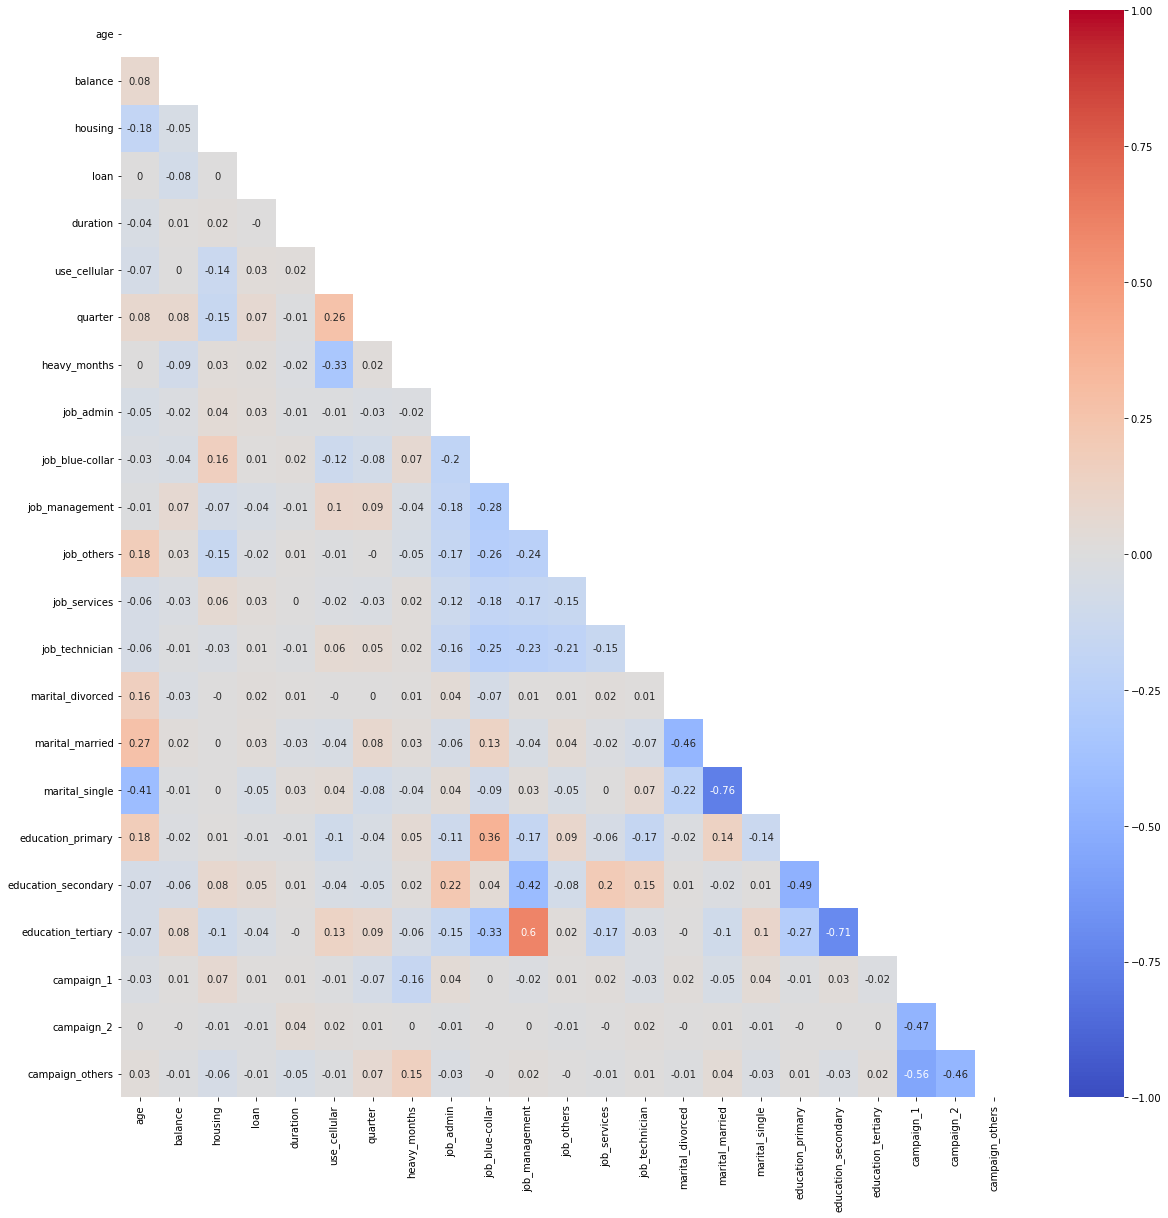

In [37]:
def visualize_correlation(X):

    # calculate all the correlations between each of the independent variables
    corr_df = X.corr()

    # mask
    mask = np.triu(corr_df)


    # heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_df.round(2), vmax=1, vmin=-1, center=0, annot=True, mask=mask, cmap='coolwarm')
visualize_correlation(dummy_df.drop('y', axis=1))

For the purpose of this analysis, we will use a correlation threshold of 0.8 to decide if two features are highly correlated. From the correlation heatmap above, we can see that `marital_single`, `marital_married` has a correlation of -0.76, and `education_teritary`, `education_secondary` has a correlation of -0.71. These two pairs has relatively high correlation but since they are still below our threshold by a little, we will keep them in the dataset.

### Saving the processed dataset

We will save the processed dataset as `tdm_preprocessed.csv` under the `data` folder.

In [38]:
dummy_df.to_csv('./data/tdm_preprocessed.csv')

## Modeling

Now that we are done with preprocessing the data, we can now move on to fitting some models to the data and get a intuition of ideal model. We might still consider removing some features if we find any features are not as important in the backward selection process.

### Balancing the classes

As we saw in the data wrangling section, 92.76% of our customers are not subscribed to a term deposit and belong to class 0, whereas only 7.24% of customers belong to class 1. This indicates strong imbalance between the classes and it will affect the performance of our models and our evaluation of them. We will combine the following methods to tackle the class imbalance issue:
- Downsampling the majority class 0
- Upsampling the minority class 1
- Consider F1 score instead of accuracy as the main evaluation metric.

In [39]:
# Preparing the training and testing dataset
from sklearn.model_selection import train_test_split

X = dummy_df.drop(columns="y")
y = dummy_df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [40]:
from sklearn.utils import resample

# Downsampling class 0
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=int(X_train[y_train == 0].shape[0]*0.7), 
                                        random_state=123)
print('Number of class 0 examples after:', X_downsampled.shape[0])

# Upsampling class 1
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                        y_train[y_train == 1], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0]*3, 
                                        random_state=123)
print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combining the data
X_train_bal = np.vstack((X_downsampled, X_upsampled))
y_train_bal = np.hstack((y_downsampled, y_upsampled))

print('Total number of examples: ', X_train_bal.shape[0])

Number of class 0 examples before: 25954
Number of class 0 examples after: 18167
Number of class 1 examples before: 2046
Number of class 1 examples after: 6138
Total number of examples:  24305


With a mix of downsampling and upsampling technique, we are able to generate a more balanced training dataset consists of 24305 examples, with 18167 entries of class 0 and 6138 entries of class 1.

Note that even after resampling, the dataset is still imbalanced:

In [41]:
zero_one_ratio = 18167/6138
print(f'Class 0 / Class 1 Ratio: {zero_one_ratio}')

Class 0 / Class 1 Ratio: 2.9597588791137177


### Normalization

To make sure the distance based models like KNN would have a reasonable performance on the data, we will normalize the data before fitting the models.

In [42]:
from sklearn.preprocessing import StandardScaler

# Normalizing the balanced training data
ss = StandardScaler()
X_train_bal = ss.fit_transform(X_train_bal)
X_test = ss.transform(X_test)

### Model Selection

Now we can start fitting some models.

In [43]:
model_candidates = [LogisticRegression(random_state=22), SVC(random_state=22), 
                    RandomForestClassifier(max_depth=10, random_state=22),
                    KNeighborsClassifier(), 
                    AdaBoostClassifier(random_state=22), 
                    xgb.XGBClassifier(random_state=22)]
model_names = ['logreg', 'SVC', 'KNN', 'RF', 'Ada', 'XGB']

for i, model in enumerate(model_candidates):
    model.fit(X_train_bal, y_train_bal)
    print(f'{model_names[i]} training accuracy: {model.score(X_train_bal, y_train_bal)}')
    print(f'{model_names[i]} testing accuracy: {model.score(X_test, y_test)}')
    print()

logreg training accuracy: 0.849043406706439
logreg testing accuracy: 0.91875

SVC training accuracy: 0.9050401152026332
SVC testing accuracy: 0.9149166666666667

KNN training accuracy: 0.9269697593087842
KNN testing accuracy: 0.92325

RF training accuracy: 0.9397243365562642
RF testing accuracy: 0.8773333333333333

Ada training accuracy: 0.859411643694713
Ada testing accuracy: 0.9103333333333333

XGB training accuracy: 0.9674552561201399
XGB testing accuracy: 0.9183333333333333



All of our models performed reasonably well on the training and testing set with beyond 85% accuracy. But considering the strong imbalance in the testing set, we would have to pick the model that have the best performance on the minority class in the test set, which is class 1. We will check out the confusion matrix and the classification report to gain more insight and choose the best model.

In [44]:
def show_confusion_matrix_and_report(model_name, model, X_train, y_train, X_test, y_test):
    print_line = '\n----------------------------------\n'
    
    print(f"Confusion matrices: {model_name}", print_line)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Model on the training data
    plot_confusion_matrix(model, X_train, y_train, ax=axes[0])
    axes[0].set_title('Confusion Matrix: Training')

    # Model on the testing data
    plot_confusion_matrix(model, X_test, y_test, ax=axes[1])
    axes[1].set_title('Confusion Matrix: Testing')
    
    plt.show()
    
    model_pred_train = model.predict(X_train)
    model_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, model_pred_train)
    report_test = classification_report(y_test, model_pred_test)
    
    print("\nTraining data classification report:", print_line, report_train)
    print("\nTesting data classification report:", print_line, report_test)

Confusion matrices: logreg 
----------------------------------



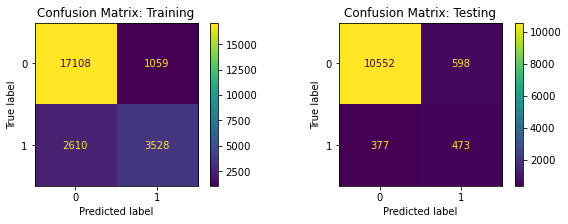


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     18167
           1       0.77      0.57      0.66      6138

    accuracy                           0.85     24305
   macro avg       0.82      0.76      0.78     24305
weighted avg       0.84      0.85      0.84     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     11150
           1       0.44      0.56      0.49       850

    accuracy                           0.92     12000
   macro avg       0.70      0.75      0.72     12000
weighted avg       0.93      0.92      0.92     12000

Confusion matrices: SVC 
----------------------------------



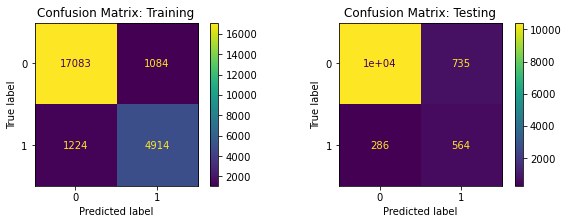


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     18167
           1       0.82      0.80      0.81      6138

    accuracy                           0.91     24305
   macro avg       0.88      0.87      0.87     24305
weighted avg       0.90      0.91      0.90     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     11150
           1       0.43      0.66      0.52       850

    accuracy                           0.91     12000
   macro avg       0.70      0.80      0.74     12000
weighted avg       0.94      0.91      0.92     12000

Confusion matrices: KNN 
----------------------------------



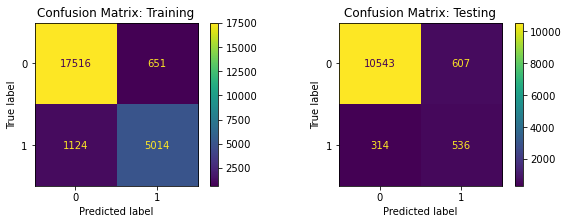


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     18167
           1       0.89      0.82      0.85      6138

    accuracy                           0.93     24305
   macro avg       0.91      0.89      0.90     24305
weighted avg       0.93      0.93      0.93     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     11150
           1       0.47      0.63      0.54       850

    accuracy                           0.92     12000
   macro avg       0.72      0.79      0.75     12000
weighted avg       0.94      0.92      0.93     12000

Confusion matrices: RF 
----------------------------------



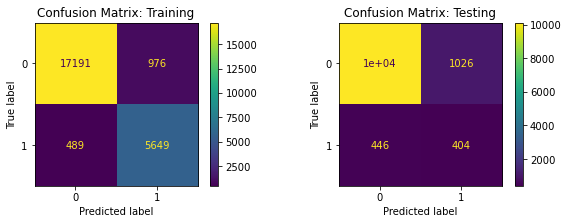


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     18167
           1       0.85      0.92      0.89      6138

    accuracy                           0.94     24305
   macro avg       0.91      0.93      0.92     24305
weighted avg       0.94      0.94      0.94     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     11150
           1       0.28      0.48      0.35       850

    accuracy                           0.88     12000
   macro avg       0.62      0.69      0.64     12000
weighted avg       0.91      0.88      0.89     12000

Confusion matrices: Ada 
----------------------------------



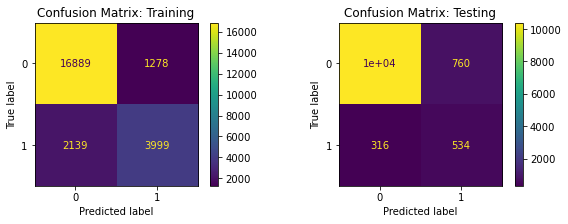


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     18167
           1       0.76      0.65      0.70      6138

    accuracy                           0.86     24305
   macro avg       0.82      0.79      0.80     24305
weighted avg       0.85      0.86      0.86     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     11150
           1       0.41      0.63      0.50       850

    accuracy                           0.91     12000
   macro avg       0.69      0.78      0.72     12000
weighted avg       0.93      0.91      0.92     12000

Confusion matrices: XGB 
----------------------------------



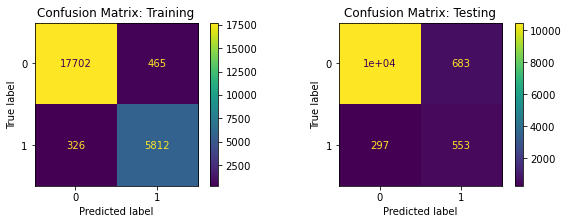


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.97      0.98     18167
           1       0.93      0.95      0.94      6138

    accuracy                           0.97     24305
   macro avg       0.95      0.96      0.96     24305
weighted avg       0.97      0.97      0.97     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.94      0.96     11150
           1       0.45      0.65      0.53       850

    accuracy                           0.92     12000
   macro avg       0.71      0.79      0.74     12000
weighted avg       0.94      0.92      0.93     12000



In [45]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

for i, model in enumerate(model_candidates):
    show_confusion_matrix_and_report(model_names[i], model, 
                                    X_train_bal, y_train_bal, X_test, y_test)

Out of all the models, KNN has a f1-score for class 1 in the testing data that is slightly better than the others at 0.54. It is followed by XGBoost which has a f1-score of 0.55. LogisticRegression model appears to be underfitting the training data although performing well on the testing data so it makes a good candidate as well.

We will see if we could further improve these two models by hyperparameter tuning.

### Hyperparameter tuning

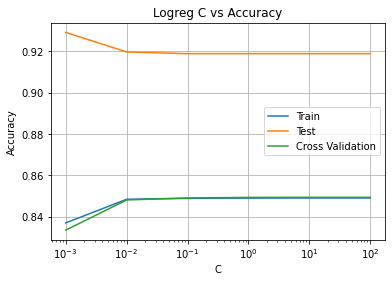

In [46]:
from sklearn.model_selection import cross_val_score

# tuning Logreg C
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores = []
test_scores = []
cv_scores = []

for C in Cs:
    logreg = LogisticRegression(C=C)
    cv_scores.append(np.mean(cross_val_score(logreg, X_train_bal, y_train_bal, cv=5)))
    logreg.fit(X_train_bal, y_train_bal)
    train_scores.append(logreg.score(X_train_bal, y_train_bal))
    test_scores.append(logreg.score(X_test, y_test))
    
plt.figure()
plt.plot(Cs, train_scores, label='Train')
plt.plot(Cs, test_scores, label='Test')
plt.plot(Cs, cv_scores, label='Cross Validation')
plt.title('Logreg C vs Accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

Looks like the default value for C is optimal. Since the resampled training dataset is still a bit imbalanced. We can assign the class weights to get a more balanced model.

Confusion matrices: logreg 
----------------------------------



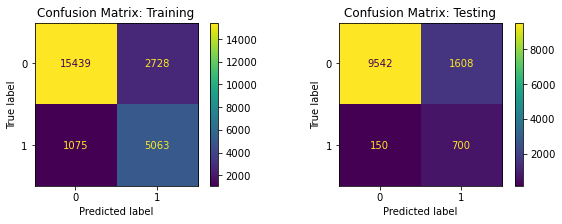


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.93      0.85      0.89     18167
           1       0.65      0.82      0.73      6138

    accuracy                           0.84     24305
   macro avg       0.79      0.84      0.81     24305
weighted avg       0.86      0.84      0.85     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.86      0.92     11150
           1       0.30      0.82      0.44       850

    accuracy                           0.85     12000
   macro avg       0.64      0.84      0.68     12000
weighted avg       0.94      0.85      0.88     12000



In [47]:
logreg = LogisticRegression(class_weight={0:1, 1:zero_one_ratio})
logreg.fit(X_train_bal, y_train_bal)
show_confusion_matrix_and_report('logreg', logreg, X_train_bal, y_train_bal, X_test, y_test)

By assigning a higher class weight to the minority class, the model emphasizes more on class 1 comparing to the baseline logreg model. The f1-score dropped from 0.49 to 0.44, but the recall score increased from 0.56 to 0.82, if we are more interested about finding more potential term deposit subscribers, we should use the balanced model over the baseline model.

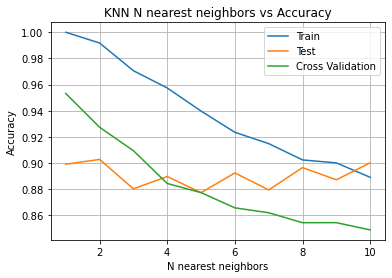

In [48]:
# tuning KNN
ns = np.arange(1,11)
train_scores = []
test_scores = []
cv_scores = []

for n in ns:
    knn = KNeighborsClassifier(n_neighbors=n)
    cv_scores.append(np.mean(cross_val_score(knn, X_train_bal, y_train_bal, cv=5)))
    knn.fit(X_train_bal, y_train_bal)
    train_scores.append(knn.score(X_train_bal, y_train_bal))
    test_scores.append(knn.score(X_test, y_test))
    
plt.figure()
plt.plot(ns, train_scores, label='Train')
plt.plot(ns, test_scores, label='Test')
plt.plot(ns, cv_scores, label='Cross Validation')
plt.title('KNN N nearest neighbors vs Accuracy')
plt.xlabel('N nearest neighbors')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

By increasing the number of nearest neighbors, we gradually reduce the overfitting and with `n_neighbors` set to 8, the training and testing accuracy become very close. So we will finalize our KNN model with `n_neighbors=8`. 

Let's take a look at its confusion matrix and classification report.

Confusion matrices: knn(n_neighbors=8) 
----------------------------------



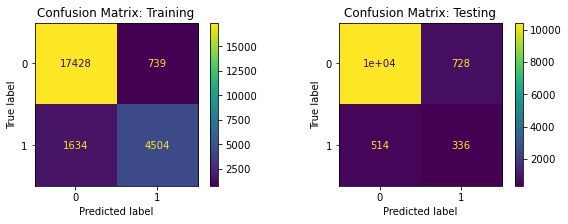


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     18167
           1       0.86      0.73      0.79      6138

    accuracy                           0.90     24305
   macro avg       0.89      0.85      0.86     24305
weighted avg       0.90      0.90      0.90     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     11150
           1       0.32      0.40      0.35       850

    accuracy                           0.90     12000
   macro avg       0.63      0.67      0.65     12000
weighted avg       0.91      0.90      0.90     12000



In [49]:
knn_final = KNeighborsClassifier(n_neighbors=8)
knn_final.fit(X_train_bal, y_train_bal)

show_confusion_matrix_and_report('knn(n_neighbors=8)', knn_final, X_train_bal, y_train_bal,
                                X_test, y_test)

The tuned KNN model has 84% testing accuracy on the test set and a f1-score of 0.35. The model has a much higher recall for class 1 of 0.40 than precision of 0.32.

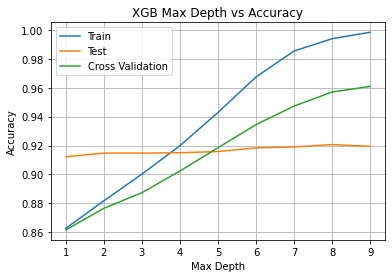

In [50]:
# Tuning XGBoost max_depth
depths = np.arange(1,10)
train_scores = []
test_scores = []
cv_scores = []

for depth in depths:
    xgb_model = xgb.XGBClassifier(max_depth=depth, random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.plot(depths, cv_scores, label='Cross Validation')
plt.title('XGB Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

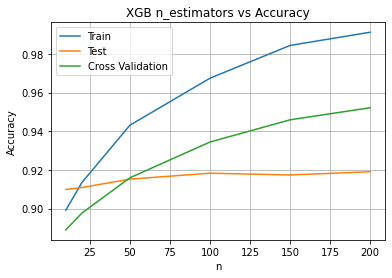

In [51]:
# Tuning XGBoost max_depth
ns = [10, 20, 50, 100, 150, 200]
train_scores = []
test_scores = []
cv_scores = []

for n in ns:
    xgb_model = xgb.XGBClassifier(n_estimators=n, max_depth=6,
                                 random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(ns, train_scores, label='Train')
plt.plot(ns, test_scores, label='Test')
plt.plot(ns, cv_scores, label='Cross Validation')
plt.title('XGB n_estimators vs Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

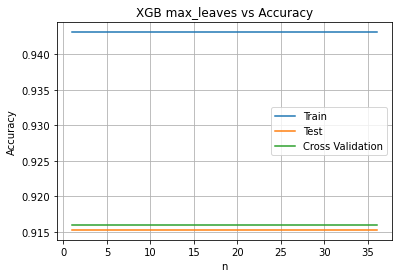

In [52]:
# Tuning XGBoost max_leaf
n_leaves = np.arange(1,41,5)
train_scores = []
test_scores = []
cv_scores = []

for n in n_leaves:
    xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=6, max_leaves=n,
                                 random_state=22)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(n_leaves, train_scores, label='Train')
plt.plot(n_leaves, test_scores, label='Test')
plt.plot(n_leaves, cv_scores, label='Cross Validation')
plt.title('XGB max_leaves vs Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Seems like our XGBoost model performs the best with `n_estimators=100` and `max_depths=7`. The `max_leaves` parameter did not make any difference. We will create the final xgb model and checkout its confusion matrix and classification report.

[22:50:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

Confusion matrices: Tuned XGB model 
----------------------------------



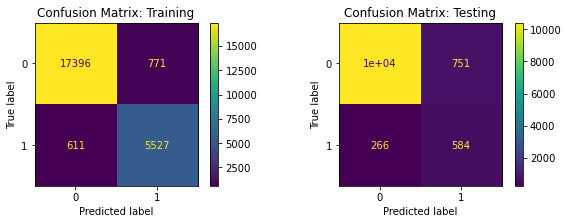


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     18167
           1       0.88      0.90      0.89      6138

    accuracy                           0.94     24305
   macro avg       0.92      0.93      0.93     24305
weighted avg       0.94      0.94      0.94     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     11150
           1       0.44      0.69      0.53       850

    accuracy                           0.92     12000
   macro avg       0.71      0.81      0.74     12000
weighted avg       0.94      0.92      0.92     12000



In [61]:
xgb_tuned = xgb.XGBClassifier(n_estimators=50, max_depths=6,random_state=22)
xgb_tuned.fit(X_train_bal, y_train_bal)
show_confusion_matrix_and_report('Tuned XGB model', xgb_tuned, X_train_bal, y_train_bal,
                                X_test, y_test)

Our tuned XGBoost model has 94% training accuracy and 92% testing accuracy and f1-score of 0.53 for class 1. It performed better than our KNN model. Thought we have different class distribution for the training and testing set, we could argue that the model is overfitting the training data.

Similar to the logreg, we can also emphasize finding the potential term deposit subscribers more by tuning the `scale_pos_weight` parameter.

[22:50:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

Confusion matrices: tuned XGB model with class weight 
----------------------------------



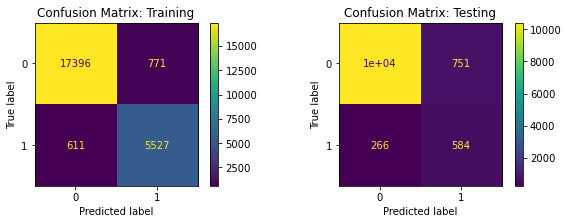


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.97      0.96      0.96     18167
           1       0.88      0.90      0.89      6138

    accuracy                           0.94     24305
   macro avg       0.92      0.93      0.93     24305
weighted avg       0.94      0.94      0.94     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     11150
           1       0.44      0.69      0.53       850

    accuracy                           0.92     12000
   macro avg       0.71      0.81      0.74     12000
weighted avg       0.94      0.92      0.92     12000



In [62]:
xgb_tuned_bal = xgb.XGBClassifier(n_estimators=50, max_depths=6, 
                                 scale_pos_weight=zero_one_ratio,
                                 random_state=22)
xgb_tuned.fit(X_train_bal, y_train_bal)
show_confusion_matrix_and_report('tuned XGB model with class weight', xgb_tuned, X_train_bal,
                                 y_train_bal, X_test, y_test)

Similar when assigning the class weights to the Logistic Regression model, despite the f1-score dropped by 4%, we are able to increase the recall of the term deposit subscribers by 13%.

Since there are no information regarding if a higher recall is more desirable, we will stick with the model with higher f1-score. In this case it is the tuned XGB model.

### Prediction Probablity Threshold vs F1-score

To further balance the precision and recall score, we can plot the f1-score against different choice of probability threshold to find the threshold that maximizes the f1-score.

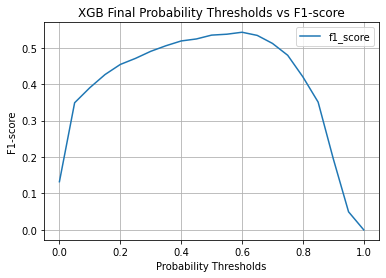

In [79]:
from sklearn.metrics import f1_score
thresholds = np.arange(21)*0.05
f1_scores = []

y_proba = xgb_tuned.predict_proba(X_test)[:,1]

for thres in thresholds:
    y_pred = np.where(y_proba > thres, 1, 0)
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure()
plt.plot(thresholds, f1_scores, label='f1_score')
plt.xlabel('Probability Thresholds')
plt.ylabel('F1-score')
plt.title('XGB Final Probability Thresholds vs F1-score')
plt.legend()
plt.grid()
plt.show()

It seems that at probability threshold of 0.6, the model achieve the maximum f1-score on the test set. So we choose 0.6 as the probability threshold of the model.

## Potential subscribers

With our final model, we can find the potential customers who are not currently subscribed to a term deposit but might be convertable. We will consider the false positives from our model's prediction as the potentially convertable customers.

In [92]:
# Normalize the entire data set
X_norm = ss.transform(X)

# Generate predicted probablity with our model
y_proba = xgb_tuned.predict_proba(X_norm)[:,1]

# Predict using the optimal threshold of 0.6
y_pred = np.where(y_proba > 0.6, 1, 0)

# Find the false positves indexes
FP = np.where((y == 0)&(y_pred == 1))[0]

# Find the potential customers in the original dataset
potential_customer_df = df.loc[FP]

We're able to construct a dataset for the potential customers, let's take a look at the data.

In [93]:
potential_customer_df.head()

,age,job,marital,education,balance,housing,loan,duration,campaign,y,use_cellular,quarter,heavy_months
37,53,technician,married,secondary,-3,0,0,1666,1,0,0,2,1
38,36,admin,divorced,secondary,506,1,0,577,1,0,0,2,1
61,53,technician,divorced,secondary,989,1,0,812,1,0,0,2,1
92,60,admin,married,secondary,290,1,0,583,1,0,0,2,1
109,45,management,married,tertiary,523,1,0,849,2,0,0,2,1


In [94]:
potential_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1670 entries, 37 to 39998
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           1670 non-null   int64 
 1   job           1670 non-null   object
 2   marital       1670 non-null   object
 3   education     1670 non-null   object
 4   balance       1670 non-null   int64 
 5   housing       1670 non-null   int64 
 6   loan          1670 non-null   int64 
 7   duration      1670 non-null   int64 
 8   campaign      1670 non-null   object
 9   y             1670 non-null   int64 
 10  use_cellular  1670 non-null   int64 
 11  quarter       1670 non-null   int64 
 12  heavy_months  1670 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 182.7+ KB


We are able to identify 1670 customers who are more likely to buy the investment product in the future.

## Feature importance

As we have a final working XGB model, we can leverage the `feature importance` of such tree based models and eliminate features that are less important.

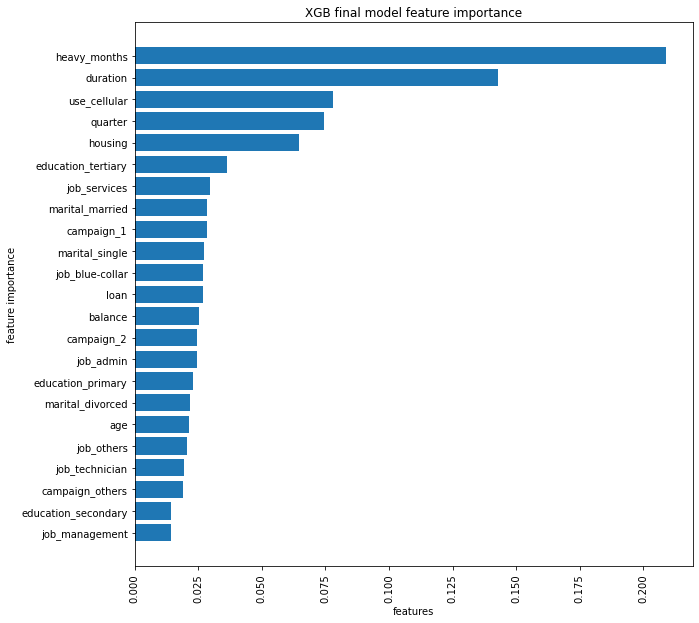

In [63]:
# Construct a importance df
importance_df = pd.DataFrame(xgb_tuned.feature_importances_, index=X.columns, columns=['Importance'])
importance_df.sort_values(by='Importance', inplace=True)

# Plot feature importance
plt.figure(figsize=(10,10))
plt.barh(importance_df.index, importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('features')
plt.ylabel('feature importance')
plt.title('XGB final model feature importance')
plt.show()

As we mentioned above, the model is somewhat overfitting the training data. We could reduce overfitting by only keeping the most important features. Here we will only keep the features with importance over 0.05.

In [69]:
# Get the feature names
selected_features = importance_df[importance_df['Importance'] > 0.05].index

# construct a df for training and testing sets
X_train_bal_df = pd.DataFrame(X_train_bal, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [70]:
# only keep the selected features
X_train_bal_df = X_train_bal_df[selected_features]
X_test_df = X_test_df[selected_features]

[22:55:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

Confusion matrices: 5 feature XGB model 
----------------------------------



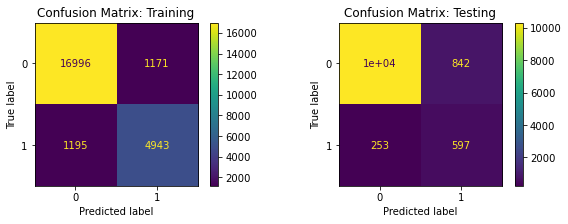


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     18167
           1       0.81      0.81      0.81      6138

    accuracy                           0.90     24305
   macro avg       0.87      0.87      0.87     24305
weighted avg       0.90      0.90      0.90     24305


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     11150
           1       0.41      0.70      0.52       850

    accuracy                           0.91     12000
   macro avg       0.70      0.81      0.74     12000
weighted avg       0.94      0.91      0.92     12000



In [71]:
# Retrain a xgb model and see the performance
xgb_5_feature = xgb.XGBClassifier(n_estimators=50, max_depths=6)
xgb_5_feature.fit(X_train_bal_df.values, y_train_bal)
show_confusion_matrix_and_report('5 feature XGB model', xgb_5_feature, X_train_bal_df.values,
                                y_train_bal, X_test_df.values, y_test)

Only using the five most important features, our XGB model has 90% accuracy on the training set and 91% accuracy on the testing set. Looks like we have addressed the overfitting well. The precision score dropped by 0.03 but the recall increased by 0.01. The f1-score dropped slightly from 0.53 to 0.52.

Since our model only using top five features would still generate a reasonable performance, we could argue that they are the most deciding factors in determining if a customer would purchase the investment product. 

Some observation and insights:
- Among the five features, `heavy_month` and `quarter` are both describing the time of the last call made which might indicate that people are more willing to purchase an investment product during some certain months in a year.
- `duration` is a important feature and it makes sense as the people who are interested in buying a product probably would spend more time on the call with the clients.
- `use_cellular` distinguishes the customer group and it shows that customers who communicate over the cellular have a different probability of purchasing the product comparing to those who don't.
- `housing` is also a good indicator probably because people who do have experience with housing loans are more likely to be familiar with the financial tools or are equipped with more investment knowledge.